In [5]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [6]:
import tensorflow as tf

In [7]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


[INFO] loading images...


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
21/21 [==============================] - 6s 261ms/step - loss: 0.3338 - accuracy: 0.8262 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 2/20
21/21 [==============================] - 5s 245ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 3/20
21/21 [==============================] - 5s 229ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/20
21/21 [==============================] - 5s 236ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 5/20
21/21 [==============================] - 5s 225ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/20
21/21 [==============================] - 5s 235ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/20
21/21 [==============================] - 5s 232ms/step - loss: 0.0031 - accuracy: 1.000

/Users/farhanisrak/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


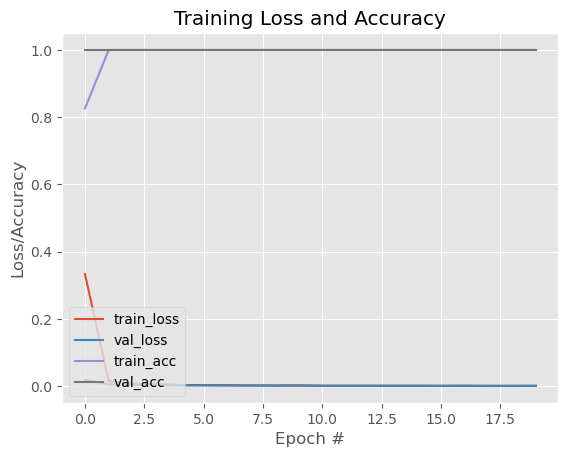

1/1 [==============================] - 0s 151ms/step


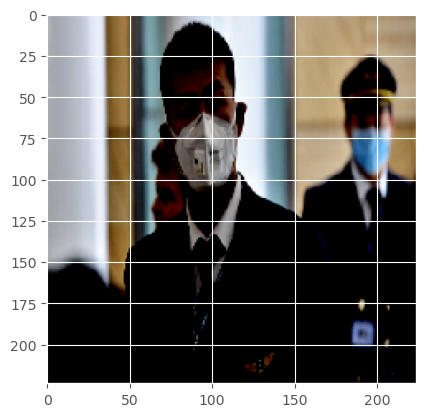

Predicted: 
0
True:
0


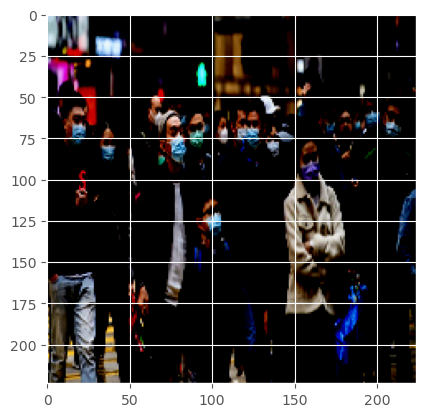

Predicted: 
0
True:
0


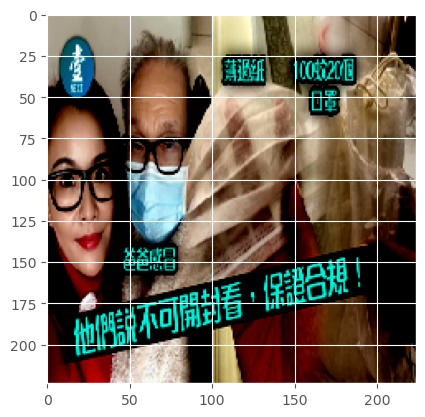

Predicted: 
0
True:
0


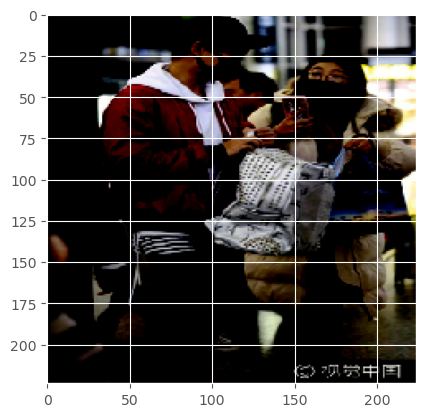

Predicted: 
0
True:
0


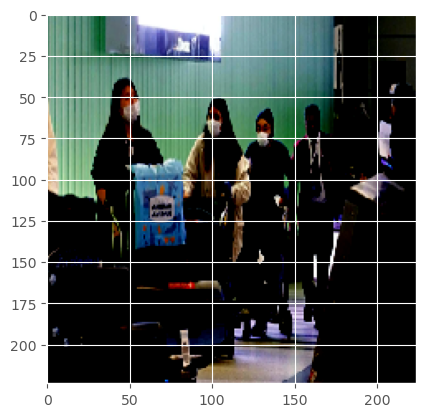

Predicted: 
0
True:
0


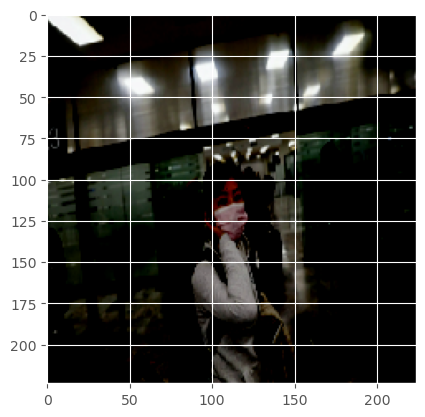

Predicted: 
0
True:
0


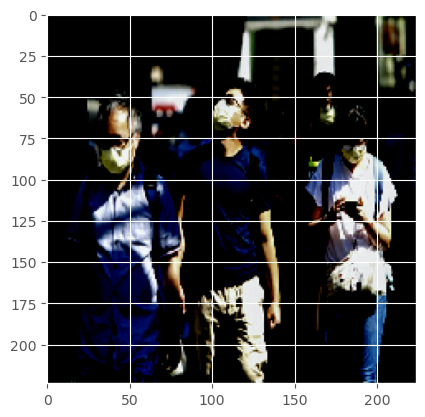

Predicted: 
0
True:
0


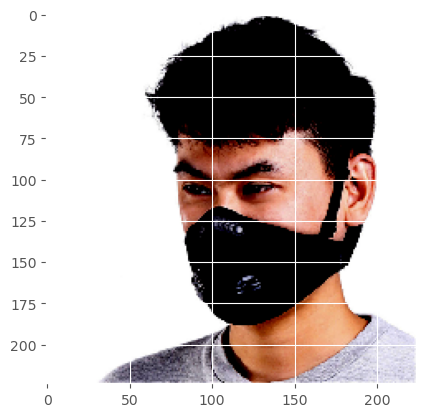

Predicted: 
0
True:
0


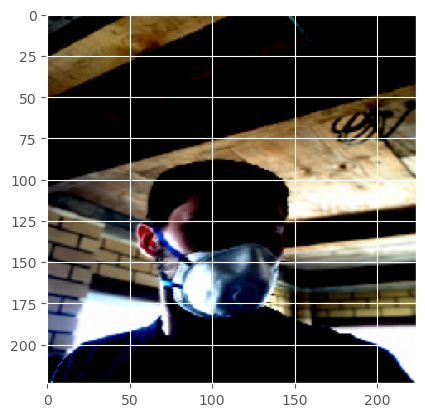

Predicted: 
0
True:
0


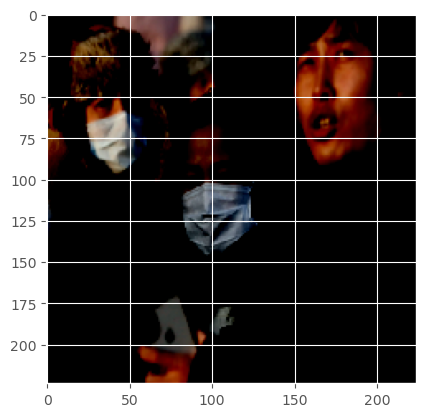

Predicted: 
0
True:
0


In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

# Set your local path
local_path = "/Users/farhanisrak/cvpr/archive"

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("[INFO] loading images...")
imagePaths = list(paths.list_images(local_path))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=EPOCHS,
    decay_rate=0.9
)
opt = Adam(learning_rate=lr_schedule)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

print("[INFO] saving mask detector model...")
model.save("./FaceMaskDetectionModel", save_format="h5")

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

# Make predictions and visualize some results
Predictions = model.predict(testX[10:20])
for i in range(10, 20):
    X_1 = testX[i]
    Y_1 = testY[i]
    plt.imshow(X_1)
    plt.show()
    print("Predicted: ")
    print(np.argmax(Predictions[i - 10]))
    print("True:")
    print(np.argmax(testY[i]))


Epoch 1/20
21/21 [==============================] - 6s 262ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 6.6755e-04 - val_accuracy: 1.0000
Epoch 2/20
21/21 [==============================] - 5s 257ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 6.5081e-04 - val_accuracy: 1.0000
Epoch 3/20
21/21 [==============================] - 5s 249ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 6.3703e-04 - val_accuracy: 1.0000
Epoch 4/20
21/21 [==============================] - 5s 239ms/step - loss: 9.4186e-04 - accuracy: 1.0000 - val_loss: 6.2520e-04 - val_accuracy: 1.0000
Epoch 5/20
21/21 [==============================] - 5s 251ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 6.1344e-04 - val_accuracy: 1.0000
Epoch 6/20
21/21 [==============================] - 5s 255ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 6.0280e-04 - val_accuracy: 1.0000
Epoch 7/20
21/21 [==============================] - 5s 243ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.9433e-

/Users/farhanisrak/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


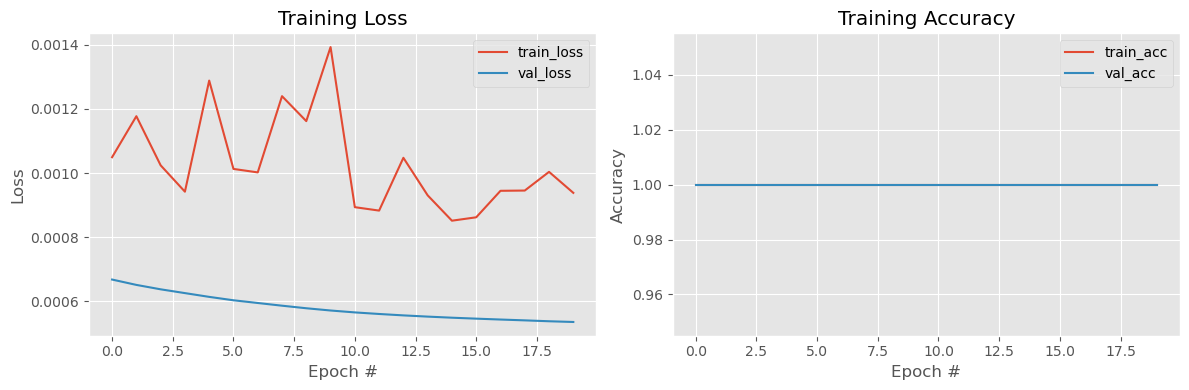

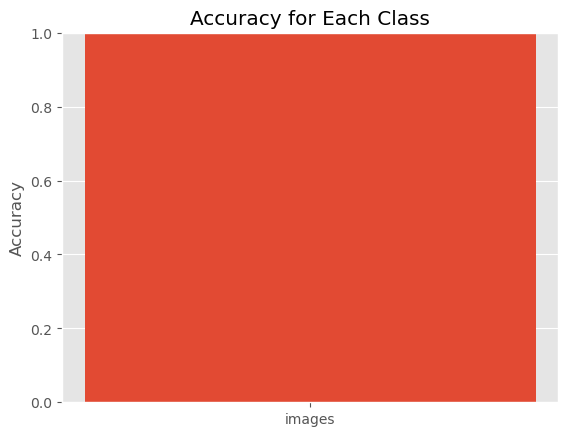

1/1 [==============================] - 0s 76ms/step


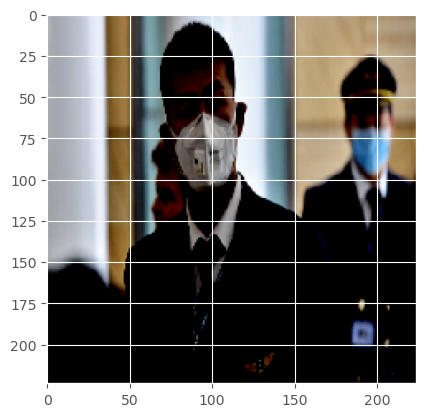

Predicted: 
0
True:
0


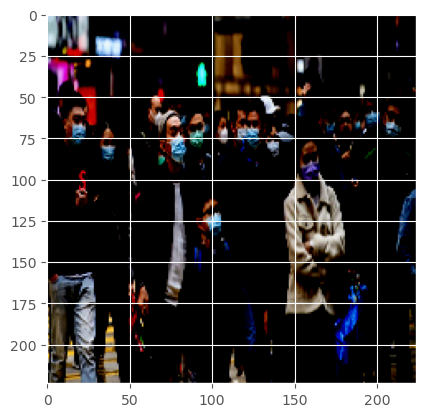

Predicted: 
0
True:
0


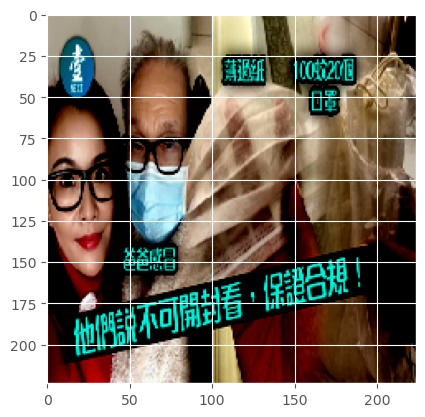

Predicted: 
0
True:
0


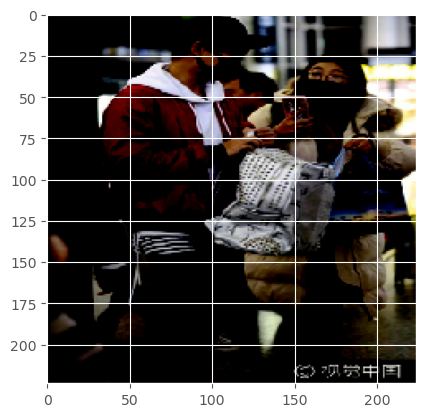

Predicted: 
0
True:
0


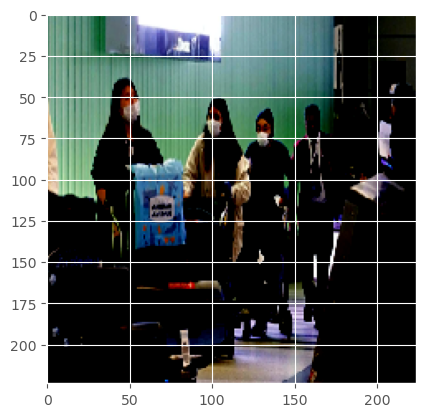

Predicted: 
0
True:
0


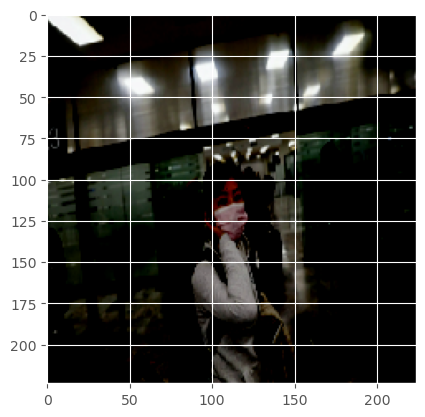

Predicted: 
0
True:
0


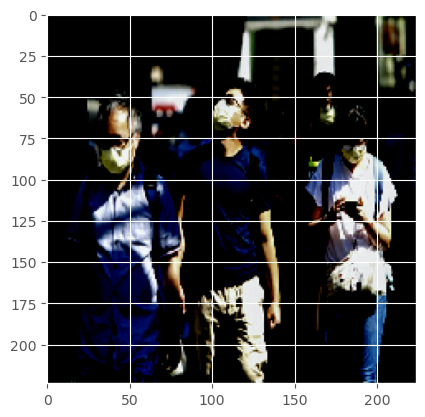

Predicted: 
0
True:
0


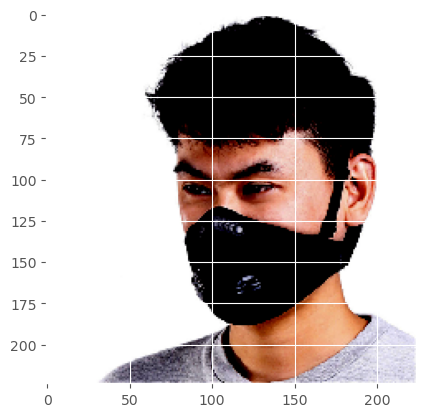

Predicted: 
0
True:
0


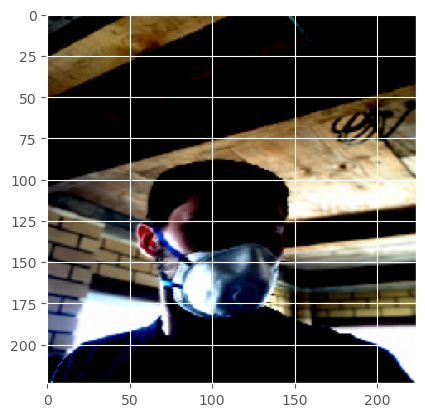

Predicted: 
0
True:
0


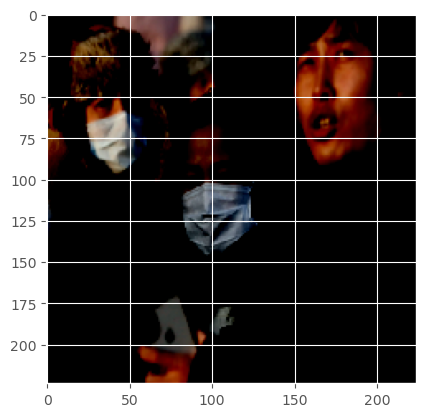

Predicted: 
0
True:
0


In [9]:
# ... (previous code)

# Training the model
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

# Evaluating the model
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# Saving the model
model.save("./FaceMaskDetectionModel", save_format="h5")

# Plotting training history
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Calculate and plot accuracy for each class
class_accuracy = {}
for i, class_name in enumerate(lb.classes_):
    class_accuracy[class_name] = (predIdxs[testY.argmax(axis=1) == i] == i).mean()

plt.bar(class_accuracy.keys(), class_accuracy.values())
plt.title("Accuracy for Each Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Make predictions and visualize some results
Predictions = model.predict(testX[10:20])
for i in range(10, 20):
    X_1 = testX[i]
    Y_1 = testY[i]
    plt.imshow(X_1)
    plt.show()
    print("Predicted: ")
    print(np.argmax(Predictions[i - 10]))
    print("True:")
    print(np.argmax(testY[i]))
